In [2]:
import sklearn
from sklearn import preprocessing
import numpy as np 

SKLEARN

STANDARDIZATION, OR MEAN REMOVAL AND VARIANCE SCALING

Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

For instance, many elements used in the objective function of a learning algorithm may assume that all features are centered around zero or have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In [4]:
x =  np.array([[1., -1., 2.], [2., 0., 0.], [0., 1., -1.]])
scaler = preprocessing.StandardScaler().fit(x)

In [5]:
scaler.mean_

array([1.        , 0.        , 0.33333333])

In [6]:
scaler.scale_

array([0.81649658, 0.81649658, 1.24721913])

In [8]:
x_scaled = scaler.transform(x)
x_scaled


array([[ 0.        , -1.22474487,  1.33630621],
       [ 1.22474487,  0.        , -0.26726124],
       [-1.22474487,  1.22474487, -1.06904497]])

Scaled data has zero mean and unit variance

In [10]:
x_scaled.mean(axis=0)

array([0., 0., 0.])

In [11]:
x_scaled.std(axis=0)

array([1., 1., 1.])

This class implements the Transformer API to compute the mean and standard deviation on a training set so as to be able to later re-apply the same transformation on the testing set. This class is hence suitable for use in the early steps of a Pipeline

It is possible to disable either centering or scaling by either passing with_mean=False or with_std=False to the constructor of StandardScaler

In [12]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

SCALING FEATURES TO A RANGE

In [15]:
x, y = make_classification(random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train)  # apply scaling on training data

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [16]:
pipe.score(x_test, y_test)  # apply scaling on testing data, without leaking training data.

0.96

An alternative standardization is scaling features to lie between a given minimum and maximum value, often between zero and one, or so that the maximum absolute value of each feature is scaled to unit size. This can be achieved using MinMaxScaler or MaxAbsScaler, respectively.

The motivation to use this scaling include robustness to very small standard deviations of features and preserving zero entries in sparse data.

In [17]:
x_train = np.array([[ 1., -1.,  2.], [ 2.,  0.,  0.], [ 0.,  1., -1.]])
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train)
x_train_minmax

array([[0.5       , 0.        , 1.        ],
       [1.        , 0.5       , 0.33333333],
       [0.        , 1.        , 0.        ]])

The same instance of the transformer can then be applied to some new test data unseen during the fit call: the same scaling and shifting operations will be applied to be consistent with the transformation performed on the train data

In [18]:
x_test = np.array([[-3., -1.,  4.]])
x_test_minmax = min_max_scaler.transform(x_test)
x_test_minmax

array([[-1.5       ,  0.        ,  1.66666667]])

It is possible to introspect the scaler attributes to find about the exact nature of the transformation learned on the training data

In [19]:
min_max_scaler.scale_

array([0.5       , 0.5       , 0.33333333])

In [20]:
min_max_scaler.min_

array([0.        , 0.5       , 0.33333333])

PANDAS 

This example will make use of the statsmodels package, and some of the description of rolling regression has benefitted from the documentation of that package.

Rolling ordinary least squares applies OLS (ordinary least squares) across a fixed window of observations and then rolls (moves or slides) that window across the data set. The key parameter is window, which determines the number of observations used in each OLS regression.

In [2]:
import pandas as pd
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

/var/folders/8c/wm8k8nc944s450hw2y569knh0000gn/T/ipykernel_22992/330413485.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


create some random numbers to do our regression on

In [3]:
x, y = make_regression(n_samples=200, n_features=2, random_state=0, noise=4.0, bias=0)
df = pd.DataFrame(x).rename(columns={0: 'feature0', 1: 'feature1'})
df['target'] = y
df.head()

,feature0,feature1,target
0,-0.955945,-0.345982,-36.740556
1,-1.225436,0.844363,7.190031
2,-0.692050,1.536377,44.389018
3,0.010500,1.785870,57.019515
4,-0.895467,0.386902,-16.088554


fit the model using a formula and a window of 25 steps

In [4]:
roll_reg = RollingOLS.from_formula('target ~ feature0 + feature1 -1', window=25, data=df)
model = roll_reg.fit()

see parameters for time steps 20-30, there aren’t parameters for entries between 0 and 23 because our window is 25 steps wide. 

In [5]:
model.params[20:30]

,feature0,feature1
20,NaN,NaN
21,NaN,NaN
22,NaN,NaN
23,NaN,NaN
24,20.736214,35.287604
25,20.351719,35.173493
26,20.368027,35.095621
27,20.532655,34.919468
28,20.470171,35.365235
29,20.002261,35.666997


look at how any of the coefficients are changing over time (ex. using feature0)

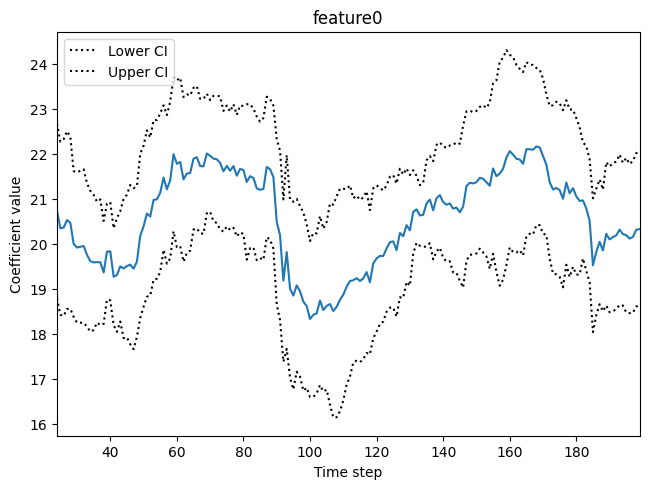

In [6]:
fig = model.plot_recursive_coefficient(variables=['feature0'])
plt.xlabel('Time step')
plt.ylabel('Coefficient value')
plt.show()

A rolling regression with an expanding (rather than moving) window is effectively a recursive least squares model. We can perform this kind of estimation using the RecursiveLS function from statsmodels. Fit this to the whole dataset

In [7]:
reg_rls = sm.RecursiveLS.from_formula(
    'target ~ feature0 + feature1 -1', df)
model_rls = reg_rls.fit()
print(model_rls.summary())

                           Statespace Model Results                           
Dep. Variable:                 target   No. Observations:                  200
Model:                    RecursiveLS   Log Likelihood                -570.923
Date:                Fri, 01 Mar 2024   R-squared:                       0.988
Time:                        10:29:16   AIC                           1145.847
Sample:                             0   BIC                           1152.444
                                - 200   HQIC                          1148.516
Covariance Type:            nonrobust   Scale                           17.413
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feature0      20.6872      0.296     69.927      0.000      20.107      21.267
feature1      34.0655      0.302    112.870      0.000      33.474      34.657
Ljung-Box (L1) (Q):                   2.02   Jarque-

look back at how the values of the coefficients changed in real time

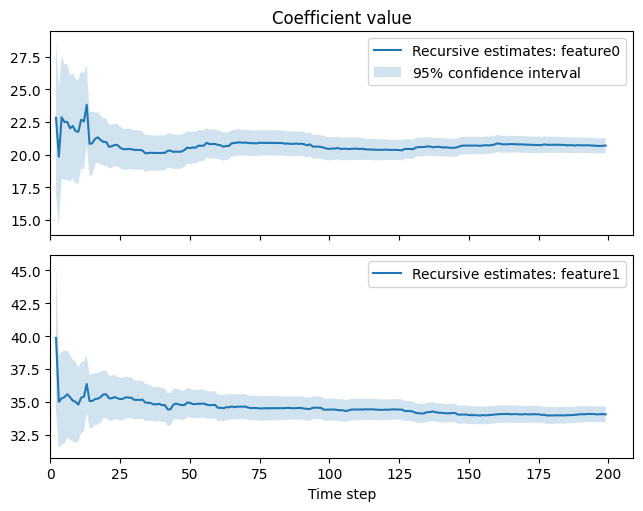

In [8]:
fig = model_rls.plot_recursive_coefficient(range(reg_rls.k_exog), legend_loc='upper right')
ax_list = fig.axes
for ax in ax_list:
    ax.set_xlim(0, None)
ax_list[-1].set_xlabel('Time step')
ax_list[0].set_title('Coefficient value');

YAHOO FINANCE DATASET USAGE

importing yfinance and from that, Microsoft data

In [9]:
import yfinance as yf
msft = yf.Ticker("MSFT")

/Users/sarenechoudhury/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


get all stock info

In [10]:
msft.info

{'address1': 'One Microsoft Way',
 'city': 'Redmond',
 'state': 'WA',
 'zip': '98052-6399',
 'country': 'United States',
 'phone': '425 882 8080',
 'website': 'https://www.microsoft.com',
 'industry': 'Software - Infrastructure',
 'industryKey': 'software-infrastructure',
 'industryDisp': 'Software - Infrastructure',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Microsoft Corporation develops and supports software, services, devices and solutions worldwide. The Productivity and Business Processes segment offers office, exchange, SharePoint, Microsoft Teams, office 365 Security and Compliance, Microsoft viva, and Microsoft 365 copilot; and office consumer services, such as Microsoft 365 consumer subscriptions, Office licensed on-premises, and other office services. This segment also provides LinkedIn; and dynamics business solutions, including Dynamics 365, a set of intelligent, cloud-based applications across ERP, CRM, power 

get historical market data

In [11]:
hist = msft.history(period="1mo")

show actions (dividends, splits, capital gains)

In [12]:
msft.actions
msft.dividends
msft.splits
msft.capital_gains  # only for mutual funds & etfs

Series([], dtype: object)

show share count

In [13]:
msft.get_shares_full(start="2022-01-01", end=None)

2022-01-27 00:00:00-05:00    7496869888
2022-02-04 00:00:00-05:00    7800719872
2022-02-05 00:00:00-05:00    7496869888
2022-02-11 00:00:00-05:00    7496869888
2022-03-04 00:00:00-05:00    7605040128
                                ...    
2024-02-15 00:00:00-05:00    7430439936
2024-02-17 00:00:00-05:00    7430439936
2024-02-23 00:00:00-05:00    7430439936
2024-02-27 00:00:00-05:00    7430439936
2024-03-01 00:00:00-05:00    7430439936
Length: 133, dtype: int64

show financials: income statement, balance sheet, cash flow statement

In [14]:
msft.income_stmt
msft.quarterly_income_stmt
msft.balance_sheet
msft.quarterly_balance_sheet
msft.cashflow
msft.quarterly_cashflow

,2023-12-31,2023-09-30,2023-06-30,2023-03-31,2022-12-31
Free Cash Flow,9118000000.0,20666000000.0,19827000000.0,17834000000.0,4899000000.0
Repurchase Of Capital Stock,-4000000000.0,-4831000000.0,-5704000000.0,-5509000000.0,-5459000000.0
Repayment Of Debt,-2916000000.0,-1500000000.0,-1000000000.0,0.0,-750000000.0
Issuance Of Debt,10773000000.0,25765000000.0,NaN,NaN,0.0
Issuance Of Capital Stock,261000000.0,685000000.0,512000000.0,536000000.0,243000000.0
Capital Expenditure,-9735000000.0,-9917000000.0,-8943000000.0,-6607000000.0,-6274000000.0
End Cash Position,17305000000.0,80452000000.0,34704000000.0,26562000000.0,15646000000.0
Beginning Cash Position,80452000000.0,34704000000.0,26562000000.0,15646000000.0,22884000000.0
Effect Of Exchange Rate Changes,72000000.0,-99000000.0,-81000000.0,29000000.0,88000000.0
Changes In Cash,-63219000000.0,45847000000.0,8223000000.0,10887000000.0,-7326000000.0


initialize multiple Ticker objects

In [15]:
tickers = yf.Tickers('msft aapl goog')

tickers.tickers['MSFT'].info
tickers.tickers['AAPL'].history(period="1mo")
tickers.tickers['GOOG'].actions

,Dividends,Stock Splits
Date,,
2014-03-27 00:00:00-04:00,0.0,2.002000
2015-04-27 00:00:00-04:00,0.0,1.002746
2022-07-18 00:00:00-04:00,0.0,20.000000


download price history into one table

In [16]:
data = yf.download("SPY AAPL", period="1mo")

[*********************100%%**********************]  2 of 2 completed


"hijack" pandas_datareader.data.get_data_yahoo() method to use yfinance while making sure the returned data is in the same format as pandas_datareader's get_data_yahoo()

In [19]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()

# download dataframe
data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")

[*********************100%%**********************]  1 of 1 completed
